In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load your dataset
df = pd.read_csv('./data/claims_data.csv')

# Define features
categorical_features = [f'cat{i}' for i in range(1, 117)]
continuous_features = [f'cont{i}' for i in range(1, 15)]

# Combine
all_features = categorical_features + continuous_features
target = 'loss'

In [3]:
for col in categorical_features:
    df[col] = df[col].astype('category')

In [4]:
X = df[all_features]
df['log_loss'] = np.log1p(df['loss'])
y = df['log_loss']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=1000
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='mae',
    categorical_feature=categorical_features,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3666
[LightGBM] [Info] Number of data points in

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [6]:
y_pred = np.expm1(model.predict(X_valid))
mae = mean_absolute_error(y_valid, y_pred)
print(f'Validation MAE: {mae:.2f}')


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Validation MAE: 2641.96


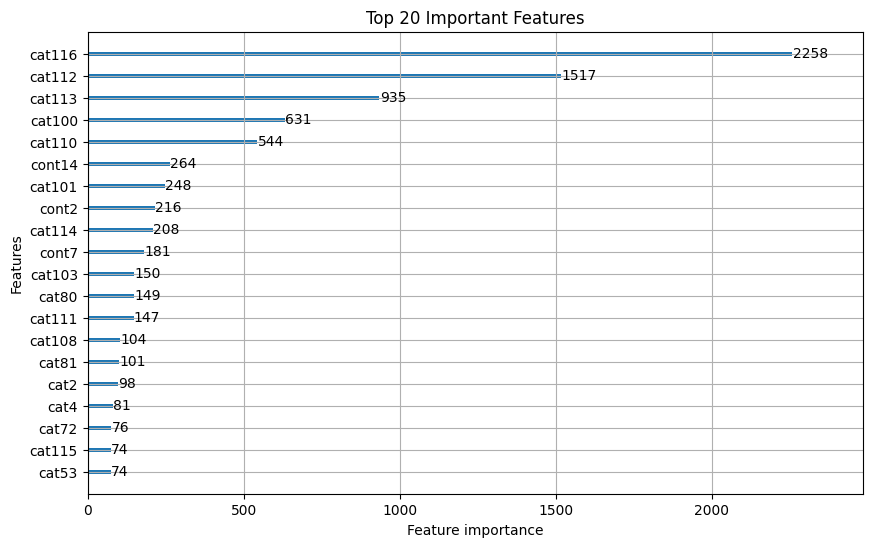

In [7]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=20, figsize=(10, 6))
plt.title("Top 20 Important Features")
plt.show()

In [ ]:
# Fine tuning code. Computer crashes every time I run.

import warnings
warnings.filterwarnings("ignore", message="No further splits with positive gain")

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.05, 0.03, 0.01],
    'feature_fraction': [0.9, 0.8, 0.7],
    'bagging_fraction': [0.9, 0.8, 0.7],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]
}

model = LGBMRegressor(
    objective='regression',
    n_estimators=1000
)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='mae',
    categorical_feature=categorical_features,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)
print("Best parameters:", grid.best_params_)
print("Best CV MAE:", -grid.best_score_)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
